In [1]:
import cv2
import torchvision
from torchvision.transforms import v2
from PIL import Image
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
import os
from datetime import datetime

In [2]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device('cpu')
device 

device(type='mps')

# Build and Train Reader Model

### Custom Model

In [3]:
data_dir = '../images/bilinear_images_5x500'

torch.manual_seed(111)

# transformations on images
transform = v2.Compose([
    v2.Grayscale(),
    v2.Resize((32,32)),
    v2.ToImage(),
    v2.ToDtype(torch.float32), # normalizes to range [0,1]
])

# create datasets
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

class_names = dataset.classes
num_classes = len(class_names)

BATCH_SIZE = 16
NUM_WORKERS = 0

# split dataset into train and val
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

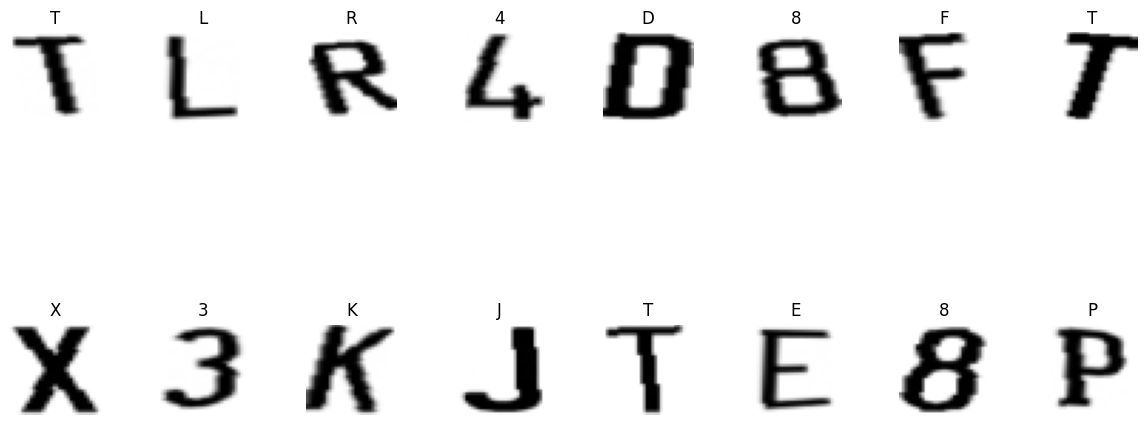

In [4]:
def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    if title:
        plt.title(title)
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# plot images with labels
fig, axes = plt.subplots(2, 8, figsize=(12, 6))
fig.tight_layout()
for i, ax in enumerate(axes.flat):
    if i < len(images):
        img = images[i] / 2 + 0.5  # unnormalize
        npimg = img.numpy()
        ax.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
        ax.set_title(class_names[labels[i]])
        ax.axis('off')
plt.show()

### Neural Nets

In [5]:
class net_1(nn.Module):
    def __init__(self):
        super(net_1, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.batch1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(3, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.batch2 = nn.BatchNorm2d(64)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64*13*13, 128)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 36) # 36 classes for 10 digits + 26 letters
        
    def forward(self, x):
        x = self.pool(self.relu(self.batch1(self.conv1(x))))
        x = self.pool(self.relu(self.batch2(self.conv2(x))))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [6]:
class net_2(nn.Module):
    def __init__(self):
        super(net_2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.batch1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.batch2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64,128, 3, 1)
        self.batch3 = nn.BatchNorm2d(128)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128*6*6, 128)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(128, 36) # 36 classes for 10 digits + 26 letters
        
    def forward(self, x):
        x = self.pool(self.relu(self.batch1(self.conv1(x))))
        x = self.pool(self.relu(self.batch2(self.conv2(x))))
        x = self.pool(self.relu(self.batch3(self.conv3(x))))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [7]:
class net_3(nn.Module):
    def __init__(self):
        super(net_3, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64,128, 3, 1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128*6*6, 64)
        self.fc2 = nn.Linear(64, 128) 
        self.fc3 = nn.Linear(128,36) # 36 classes for 10 digits + 26 letters
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
class net_4(nn.Module):
    def __init__(self):
        super(net_4, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64,128, 3, 1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128*2*2, 64)
        self.fc2 = nn.Linear(64, 128) 
        self.fc3 = nn.Linear(128,36) # 36 classes for 10 digits + 26 letters
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.flatten(x)
        #print(x.shape)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
class net_5(nn.Module):
    def __init__(self):
        super(net_5, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64,128, 3, 1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128*2*2, 64)
        self.dropout = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(64, 128) 
        self.fc3 = nn.Linear(128,36) # 36 classes for 10 digits + 26 letters
        
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


### Setup and Training

In [10]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [11]:
def train(model, device, data_loader, optimizer, criterion, epoch):
    model.train()
    epoch_loss = 0
    for batch, (data,target) in enumerate(data_loader):
        data, target = data.to(device),target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item()
        if batch % 100 == 0:
            print(f'Train Epoch {epoch} [{batch * len(data)}/{len(data_loader.dataset)}] Loss: {loss.item()}')
    epoch_loss /= len(data_loader)
    # for name, param in model.named_parameters():
    #     if param.requires_grad:
    #         print(f'{name}, weights: {param.data}')
    return epoch_loss

def validate(model, device, data_loader, criterion):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
            pred = output.argmax(dim=1,keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    val_loss /= len(data_loader)
    accuracy = correct/len(data_loader.dataset)
    acc_pct = 100. * accuracy
    print(f'\nValidation set: Average Loss: {val_loss:.4f}, Accuracy: {correct}/{len(data_loader.dataset)} ({100. * accuracy:.0f}%)\n')
    return val_loss, acc_pct

Dataset:  ../images/bilinear_images_5x500
Train Epoch 0 [0/72144] Loss: 699.3773193359375
Train Epoch 0 [1600/72144] Loss: 61.99969482421875
Train Epoch 0 [3200/72144] Loss: 31.50464630126953
Train Epoch 0 [4800/72144] Loss: 3.642320394515991
Train Epoch 0 [6400/72144] Loss: 3.8036417961120605
Train Epoch 0 [8000/72144] Loss: 3.773327589035034
Train Epoch 0 [9600/72144] Loss: 3.3795480728149414
Train Epoch 0 [11200/72144] Loss: 3.3234338760375977
Train Epoch 0 [12800/72144] Loss: 3.443507671356201
Train Epoch 0 [14400/72144] Loss: 3.830934524536133
Train Epoch 0 [16000/72144] Loss: 3.579047918319702
Train Epoch 0 [17600/72144] Loss: 4.80034065246582
Train Epoch 0 [19200/72144] Loss: 3.580235481262207
Train Epoch 0 [20800/72144] Loss: 3.3686461448669434
Train Epoch 0 [22400/72144] Loss: 3.6503524780273438
Train Epoch 0 [24000/72144] Loss: 3.4732813835144043
Train Epoch 0 [25600/72144] Loss: 3.369296073913574
Train Epoch 0 [27200/72144] Loss: 3.425719738006592
Train Epoch 0 [28800/72144]

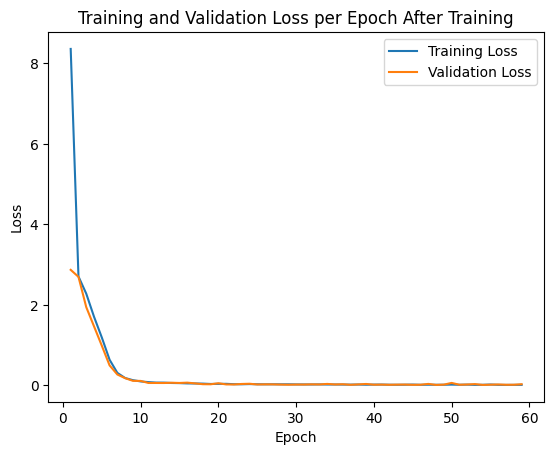

In [12]:
model = net_4()
model.apply(weights_init)
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', 0.5, 10)

epochs = 100

train_losses = []
val_losses = []
val_acc = []

best_val_loss = float('inf')
patience = 10
epochs_since_improvement = 0

print("Dataset: ", data_dir)
dd = data_dir.replace('../images','')
parent = '../saved_reader_model'
child = f'{model._get_name()}_{epochs}_{dd}_{BATCH_SIZE}'
full_path = os.path.join(parent, child)
os.makedirs(full_path, exist_ok=True)

for e in range(epochs):
    train_loss = train(model,device,train_loader,optimizer,loss_fn,e)
    val_loss, acc = validate(model,device,val_loader,loss_fn)
    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_acc.append(acc)

    
    if val_loss < best_val_loss:
        epochs_since_improvement = 0
        if e > int(epochs*0.3):
            val_loss_string = str(f'{val_loss:.4f}').replace('.','-')
            timestamp = datetime.now().strftime('%m-%d-%Y_%H:%M:%S')
            save_model = f'{timestamp}_{val_loss_string}.pth'
            final_path = os.path.join(full_path, save_model)
            best_val_loss = val_loss
            torch.save(model, final_path)
            print("saved at: ", final_path)
    else:
        epochs_since_improvement+=1

    if epochs_since_improvement > patience:
        print("Early Stop")
        break

plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch After Training')
plt.legend()
plt.show()

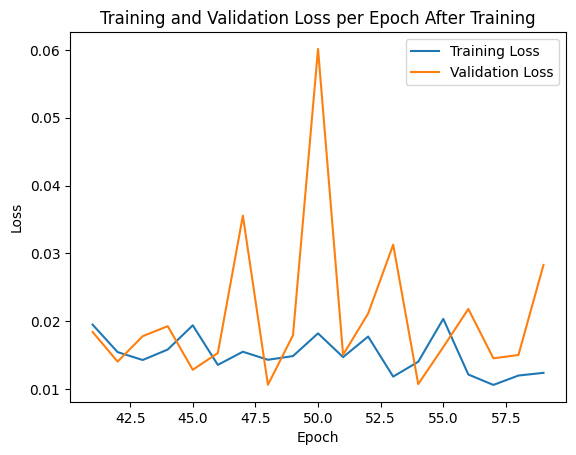

In [13]:
start = 40
plt.plot(range(start+1, len(train_losses) + 1), train_losses[start:], label='Training Loss')
plt.plot(range(start+1, len(val_losses) + 1), val_losses[start:], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch After Training')
plt.legend()
plt.show()

# Extract Text From License Plate

### Run Detection Model

In [15]:
INPUT_WIDTH = 640
INPUT_HEIGHT = 640

In [16]:
def get_detections(img,net):
    # convert image to yolo format
    image = img.copy()
    row, col, d = image.shape
    max_rc = max(row,col)
    input_image = np.zeros((max_rc,max_rc,3),dtype=np.uint8)
    input_image[0:row,0:col] = image
    

    # get prediction from yolo model
    blob = cv2.dnn.blobFromImage(input_image,1/255,(INPUT_WIDTH,INPUT_HEIGHT),swapRB=True,crop=False)
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]
    return input_image,detections

def non_maximum_supression(input_image,detections):
    # filter detections based on confidence and probability score
    # center x,center y, w, h, conf, proba
    boxes=[]
    confidences=[]

    image_w,image_h = input_image.shape[:2]
    x_factor = image_w/INPUT_WIDTH
    y_factor = image_h/INPUT_HEIGHT

    for i in range(len(detections)):
        row = detections[i]
        confidence = row[4] # confidence of detecting license plate
        if confidence > 0.4: 
            class_score = row[5] # probability score of license plate
            if class_score > 0.25: 
                cx,cy,w,h = row[0:4] # extract bounding box coordinates
                # scale boudning box coordinates to original size
                left = int((cx-0.5*w)*x_factor)
                top = int((cy-0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)
                box = np.array([left,top,width,height])

                confidences.append(confidence)
                boxes.append(box)

    # convert lists to required format for NMS
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()
    # Non Maximum Suppression (NMS)
    # removes redundant overlapping boxes based on their confidence scores
    index = cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.25,0.45)

    return boxes_np,confidences_np,index

def drawings(image, boxes_np,confidences_np,index):
    cropped_images = []
    bboxes = []
    # iterate over each index provided by NMS
    for ind in index:
        x,y,w,h = boxes_np[ind] # extract bounding box coordinates
        bb_conf = confidences_np[ind] # extract confidence
        conf_text = 'plate {:.0f}%'.format(bb_conf*100) # format confidence text

        #cv2.rectangle(image,(x,y),(x+w,y+h),(255, 0, 255),1) # draw bounding box on the image
  
        roi = image[y:y+h, x:x+w]
        cropped_images.append(roi)
        bboxes.append((x, y, w, h))

    return image, cropped_images, bboxes


In [17]:
def bbox_predictions(img,net):
    input_image,detections=get_detections(img,net)
    boxes_np,confidences_np,index = non_maximum_supression(input_image,detections)
    result_img, cropped_images, bboxes = drawings(input_image,boxes_np,confidences_np,index)
    return result_img, cropped_images, bboxes

In [18]:
# path parameter
path =  '../images/data/test/IMG_8622.png'
full_image = io.imread(path)
# detect model parameter
net = cv2.dnn.readNetFromONNX('../yolov5/runs/train/Model19/weights/best.onnx')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

img, imgs, bboxes = bbox_predictions(full_image, net)

FileNotFoundError: No such file: '/Users/shayanmirza/licensePlateRecognition/images/data/test/IMG_8622.png'

In [ ]:
license_image = img
for i, cropped_img in enumerate(imgs):
    license_image = cropped_img
    break

plt.imshow(license_image)


### Get Contours From Detected Plate

In [19]:
def preprocess_image(image):
    image = cv2.resize(image, (300,150))
    print(image.shape)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off') 
    plt.show()
    # convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # convert grayscale image to binary image (black and white)
    _, binary = cv2.threshold(gray, 95, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    # print(binary.shape)
    # plt.imshow(binary, cmap='gray')
    # plt.title('Binary Image')
    # plt.axis('off') 
    # plt.show()
    return binary

def find_contours(binary_image):
    # detect contours, which are curves joining all the continuous points along a boundary
    contours, _ = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    
    character_contours = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if 53 <= h <= 81 and 19 <= w <= 46:
            character_contours.append(contour) 
    #character_contours = sorted(contours, key=cv2.contourArea, reverse=True)[1:8]
    return character_contours


def extract_characters(contours, binary_image):
    character_images = []
    bounding_boxes = [cv2.boundingRect(c) for c in contours]
    bounding_boxes = sorted(bounding_boxes, key = lambda x: x[0])
    for box in bounding_boxes:
        x, y, w, h = box
        char_image = binary_image[y:y+h, x:x+w]
        #char_image = cv2.resize(char_image, (32,32))
        character_images.append(char_image)
    return character_images

def segment_characters(license_image):
    binary_image = preprocess_image(license_image)
    contours = find_contours(binary_image)
    character_images = extract_characters(contours,binary_image)
    # for i, char in enumerate(character_images):
    #     print(char.shape)
    #     plt.figure()
    #     plt.imshow(char, cmap='gray')
    #     plt.title(f'Cropped Character {i+1}')
    #     plt.axis('off')
    #     plt.show()
    return character_images

In [20]:
def recognize_character(img, model, class_names, transform):
    model.eval()
    
    img = Image.fromarray(img)
    img = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(img)
        probabilities = output.squeeze().cpu().numpy()
    
    predicted_index = probabilities.argmax()
    predicted_class = class_names[predicted_index]
    confidence_score = probabilities[predicted_index]

    
    confidence_scores = {class_names[i]: prob for i, prob in enumerate(probabilities)}
    
    
    return predicted_class, confidence_score, confidence_scores
          

In [21]:
def full_code(path, detect_model, read_model, class_names):
    full_image = io.imread(path)
    _, cropped_images, _ = bbox_predictions(full_image,detect_model) # detect license plates in image
    license_plate_image = cropped_images[0] # get first license plate detected
    char_imgs = segment_characters(license_plate_image) # segment characters on license plate
    transform = v2.Compose([
        v2.Grayscale(),
        v2.Resize((32,32)),
        v2.ToImage(),
        v2.ToDtype(torch.float32), # normalizes to range [0,1]
    ])
    for i, img in enumerate(char_imgs): # read and display each character on the plate
        plt.subplot(1, len(char_imgs), i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        predicted_class, confidence_score, confidence_scores = recognize_character(img, read_model, class_names, transform)
        confidence_scores = dict(sorted(confidence_scores.items(), key=lambda item: item[1], reverse=True))
        print(f'Value: {predicted_class}')
        chars = list(confidence_scores.keys())
        logits = np.array(list(confidence_scores.values()))
        logits = np.array(logits, dtype=np.float64)
        softmax_probs = np.exp(logits) / np.sum(np.exp(logits))
        softmax_confidence_scores = dict(zip(chars, softmax_probs))
        print(f'Probabilities: {list(softmax_confidence_scores.items())[:4]}')

### Run Full Code

(150, 300, 3)


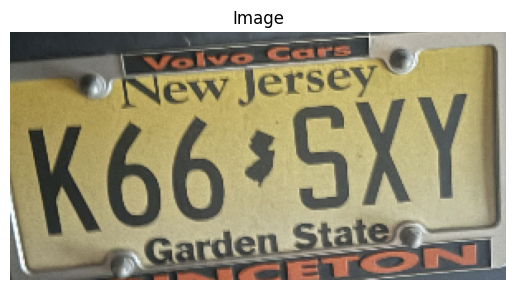

Value: K
Probabilities: [('K', np.float64(1.0)), ('W', np.float64(2.3301858023262937e-111)), ('X', np.float64(4.995568654951385e-157)), ('A', np.float64(2.9851288040405623e-203))]
Value: 6
Probabilities: [('6', np.float64(1.0)), ('G', np.float64(2.234405418883527e-43)), ('5', np.float64(2.6342363518110446e-68)), ('8', np.float64(8.545069490343087e-69))]
Value: 6
Probabilities: [('6', np.float64(1.0)), ('G', np.float64(2.1153956942649333e-43)), ('5', np.float64(1.1744508385025385e-68)), ('8', np.float64(6.227903451666255e-69))]
Value: S
Probabilities: [('S', np.float64(1.0)), ('5', np.float64(4.583954938942513e-26)), ('1', np.float64(8.24456571741397e-45)), ('X', np.float64(9.155049735386753e-68))]
Value: X
Probabilities: [('X', np.float64(1.0)), ('A', np.float64(2.4121913460890173e-149)), ('W', np.float64(1.8839218279752326e-162)), ('S', np.float64(6.942809167015539e-164))]
Value: Y
Probabilities: [('Y', np.float64(1.0)), ('X', np.float64(8.988952599981968e-73)), ('V', np.float64(1.505

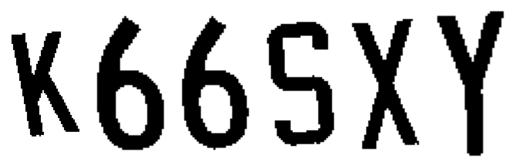

In [54]:
# path parameter
path =  '../images/data/test/test1.png'
# detect model parameter
net = cv2.dnn.readNetFromONNX('../yolov5/runs/train/Model19/weights/best.onnx')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
# read model parameter
reader = torch.load('../saved_reader_model/net_4_100_/bilinear_images_5x500_16/07-30-2024_18:49:19_0-0106.pth')

reader = reader.to(device)
reader.eval()
# class names parameter
class_names = dataset.classes

full_code(path,net,reader,class_names)
